In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr
from subprocess import check_output

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap
import matplotlib as mpl
sns.set(font_scale=1.5, style="white")

import dask.bag as db
from dask.diagnostics import ProgressBar
ProgressBar().register()

/ssd1/home/kdorosch/software/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import precalculated decodings

In [4]:
precalc_files = [os.path.join("synthetic_tags", x) for x in os.listdir("synthetic_tags")]

In [5]:
precalc_files

['synthetic_tags/08_28_2019_run_01_code20_100k_scaled.tsv',
 'synthetic_tags/08_28_2019_run_01_code9_100k_scaled.tsv',
 'synthetic_tags/08_28_2019_run_01_code48_100k_scaled.tsv',
 'synthetic_tags/08_28_2019_run_01_code74_100k_scaled.tsv',
 'synthetic_tags/08_28_2019_run_01_code82_100k_scaled.tsv',
 'synthetic_tags/08_30_2019_run_01_code62_100k_scaled.tsv',
 'synthetic_tags/08_30_2019_run_01_code81_100k_scaled.tsv',
 'synthetic_tags/08_30_2019_run_01_code76_100k_scaled.tsv',
 'synthetic_tags/09_05_2019_run_02_code62_100k_scaled.tsv',
 'synthetic_tags/09_05_2019_run_02_code81_100k_scaled.tsv',
 'synthetic_tags/09_05_2019_run_02_code76_100k_scaled.tsv',
 'synthetic_tags/10_11_19_run_02_misl_100k_scaled.tsv']

In [6]:
run_name_label = {'08_28_2019_run_01': "0", 
                  '08_30_2019_run_01': "1", 
                  '10_11_19_run_02': "misl test set", 
                  '09_05_2019_run_02': "2",}
run_name_counter = {'08_28_2019_run_01': 0, 
                  '08_30_2019_run_01': 0, 
                  '10_11_19_run_02': 0, 
                  '09_05_2019_run_02': 0,}
tag_no = 0
files_and_labels = {}
for fname in sorted(precalc_files):
    if fname in ["synthetic_tags/08_28_2019_run_01_code6_100k_scaled.tsv", "synthetic_tags/08_30_2019_run_01_code6_100k_scaled.tsv"]:
        continue
    
    print(fname)
    if not fname.endswith(".tsv"):
        continue
    r = re.findall(r"([\d]+_[\d]+_[\d]+_run_[\d]+)_(?:code([\d]+)|misl)", fname)
    print(r)
    run_name, codeword_no = r[0]
    if codeword_no is not '':
        c = run_name_counter[run_name]
        label = f"Tag {run_name_label.get(run_name)}-{c}"
        tag_no += 1
        run_name_counter[run_name] += 1
    else:
        label = "MISL tag"
    files_and_labels[fname] = label
    

synthetic_tags/08_28_2019_run_01_code20_100k_scaled.tsv
[('08_28_2019_run_01', '20')]
synthetic_tags/08_28_2019_run_01_code48_100k_scaled.tsv
[('08_28_2019_run_01', '48')]
synthetic_tags/08_28_2019_run_01_code74_100k_scaled.tsv
[('08_28_2019_run_01', '74')]
synthetic_tags/08_28_2019_run_01_code82_100k_scaled.tsv
[('08_28_2019_run_01', '82')]
synthetic_tags/08_28_2019_run_01_code9_100k_scaled.tsv
[('08_28_2019_run_01', '9')]
synthetic_tags/08_30_2019_run_01_code62_100k_scaled.tsv
[('08_30_2019_run_01', '62')]
synthetic_tags/08_30_2019_run_01_code76_100k_scaled.tsv
[('08_30_2019_run_01', '76')]
synthetic_tags/08_30_2019_run_01_code81_100k_scaled.tsv
[('08_30_2019_run_01', '81')]
synthetic_tags/09_05_2019_run_02_code62_100k_scaled.tsv
[('09_05_2019_run_02', '62')]
synthetic_tags/09_05_2019_run_02_code76_100k_scaled.tsv
[('09_05_2019_run_02', '76')]
synthetic_tags/09_05_2019_run_02_code81_100k_scaled.tsv
[('09_05_2019_run_02', '81')]
synthetic_tags/10_11_19_run_02_misl_100k_scaled.tsv
[('1

In [7]:
s = []
for fname in files_and_labels.keys():
    if not fname.endswith(".tsv"):
        continue
    subsample_df = pd.read_csv(fname, sep="\t", index_col=None, comment="#")
    subsample_df["fname"] = fname
    s.append(subsample_df)
subsample_df = pd.concat(s)

# Plot data 
## Distribution of correct vs incorrect decoding scores

Text(0.5, 1.0, 'Distribution of closest distances\nfor incorrect and correct decodings')

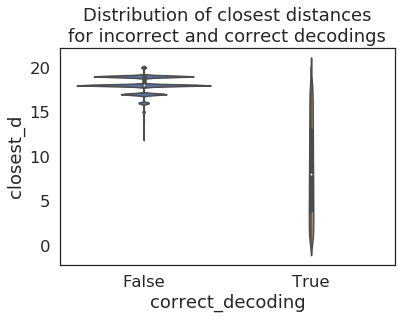

In [8]:
sns.violinplot(data=subsample_df, x="correct_decoding", y="closest_d",)#hue="correct_decoding")
plt.title("Distribution of closest distances\nfor incorrect and correct decodings")

## Prep for distance over time fn

### Find the closest depth & whether the decoding was correct

In [9]:
# How many of the samples/depths/thresholds have at least one decoding w/ distance d=12 or lower?

depth_i = 0
closest_depth_df = []
for fname, df in subsample_df.groupby("fname"):
    for depth, depth_df in df.groupby("sample_depth"):
    
        for sample_i, sample_df in depth_df.groupby("sample_i"):
            ts = sample_df["t"]
            ds = sample_df["closest_d"]
            min_d_ix = np.argmin(ds)
            min_d = ds[min_d_ix]
            correct = sample_df.loc[min_d_ix, "correct_decoding"]
            if min_d <= 14:
                closest_depth_df.append((depth, sample_i, True, min_d, correct, fname))
            else:
                closest_depth_df.append((depth, sample_i, False, min_d, correct, fname))
closest_depth_df = pd.DataFrame(closest_depth_df, columns=["sample_depth", "sample_i", "has_distance <=14", "closest_d", "correct_decoding", "fname"])

/ssd1/home/kdorosch/software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


### Aggregate error rates for each depth

In [10]:
errs_over_time_data = {}
for fname, fname_df in closest_depth_df.groupby("fname"):
    errs_over_time_data[fname] = {}
    sampled_runtime = []
    mean_dist = []
    std_dist = []
    # incorrect_depth = []
    # incorrect_dist = []
    for depth, df in fname_df.groupby("sample_depth"):
        sampled_runtime.append(depth / 4000. * 60)
        mean_dist.append(np.mean(df["closest_d"]))
        std_dist.append(np.std(df["closest_d"]))

    errs_over_time_data[fname]["sampled_runtime"] = sampled_runtime
    errs_over_time_data[fname]["mean_dist"] = mean_dist
    errs_over_time_data[fname]["std_dist"] = std_dist
    
    df = fname_df[fname_df["correct_decoding"] == False]
    depths = df["sample_depth"]/ 4000. * 60
    dists = df["closest_d"] 
    
    errs_over_time_data[fname]["incorrect_pts"] = list(zip(depths, dists))

In [11]:
colors = []
for i, color in enumerate(get_cmap('tab20').colors):
    colors.append(color)
new_colors = []
for i in range(0, len(colors), 2):
    new_color = np.mean(colors[i:i+2], axis=0)
    new_colors.extend([colors[i], new_color, colors[i+1]])
#     if i % 4 == 3:
#         colors.append((max([0, color[0] - 0.13]), max([0, color[1] - 0.13]), max([0, color[2] - 0.13])))
colors = new_colors[:]

In [12]:
color_by_file = {}
blues = colors[:3]
oranges = colors[3:6]
greens = colors[6:9]
reds = colors[9:12]
purples = colors[12:15]
browns = colors[15:18]
pinks = colors[18:21]
grays = colors[21:24]
olives = colors[24:27]
cyans = colors[27:30]
label_order = []
for fname, details in sorted(files_and_labels.items()):
    
    if "Tag 0" in details:
        try:
            color_by_file[fname] = blues.pop(0)
        except IndexError:
            continue
    elif "Tag 1" in details:
        color_by_file[fname] = oranges.pop(0)
    elif "Tag 2" in details:
        color_by_file[fname] = cyans.pop(0)
    else:
        color_by_file[fname] = "k"
    label_order.append(fname)
        

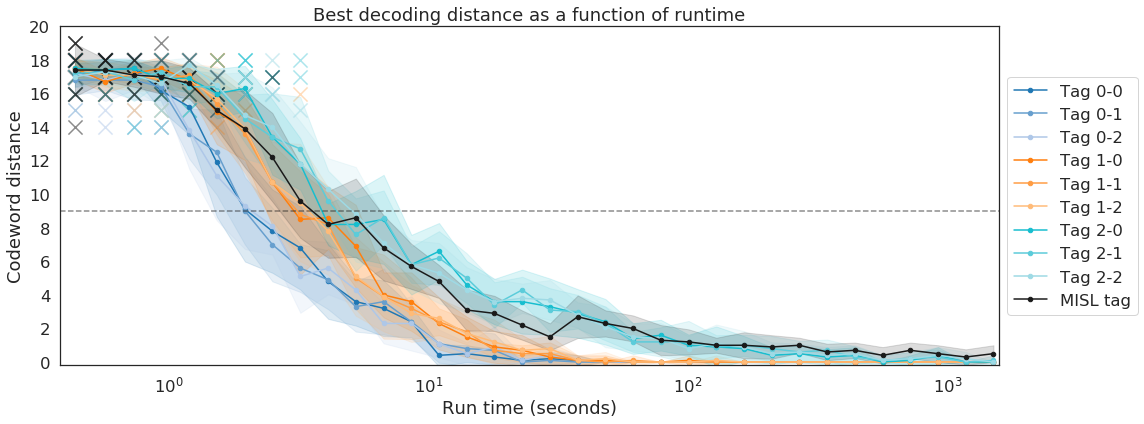

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))
for i, fname in enumerate(label_order):
    data = errs_over_time_data[fname]
    label = files_and_labels.get(fname)
    color = color_by_file[fname]
    ax.plot(data["sampled_runtime"], data["mean_dist"], linestyle='-', marker='.', c=color, label=f"{label}", ms=9)
    ax.fill_between(data["sampled_runtime"],
                [y - s for y, s in zip(data["mean_dist"], data["std_dist"])],
                [y + s for y, s in zip(data["mean_dist"], data["std_dist"])],
                color=color, alpha=0.15)
    incorrect_pts = data["incorrect_pts"]
    x, y = list(zip(*incorrect_pts))
    if len(incorrect_pts) > 0:
        ax.scatter(x, y, marker="x", color=color, alpha=0.5, s=200)#label=f"Incorrect decoding: {labels[i]}", s=200)

ax.set_xlabel("Run time (seconds)")
ax.set_ylabel("Codeword distance")
ax.set_title("Best decoding distance as a function of runtime")
# ax.set_xlim([0.01, ax.get_xlim()[1]])
ax.set_ylim([-0.2, 20])
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xscale("log")
ax.set_yticks(range(0, 21, 2))
ax.set_yticklabels([str(x) for x in range(0, 21, 2)])

ax.set_xlim([0.38, 1575])
ax.axhline(9, c="k", alpha=0.5, linestyle="--")

fig.tight_layout()

fig.savefig("../plots/time_to_decode/distance_over_time.png", dpi=300)
fig.savefig("../plots/time_to_decode/distance_over_time.svg")

In [14]:
depth_i = 0
max_d = 10
first_d_below_maxd = []
for fname, fname_df in subsample_df.groupby("fname"):
    for depth, depth_df in fname_df.groupby("sample_depth"):
        for sample_i, sample_df in depth_df.groupby("sample_i"):
            ts = sample_df["t"]
            ds = sample_df["closest_d"]

            found = False
            for i, d in ds.iteritems():
                if d <= max_d:
                    found = True
                    correct = sample_df.loc[i, "correct_decoding"]
                    first_d_below_maxd.append((depth, sample_i, True, d, ts[i], correct, fname))
                    break
            if not found:
                first_d_below_maxd.append((depth, sample_i, False, None, None, None, fname))
first_d_below_maxd = pd.DataFrame(first_d_below_maxd, columns=["sample_depth", "sample_i", "has_distance <=14", "d", "t", "correct_decoding", "fname"])

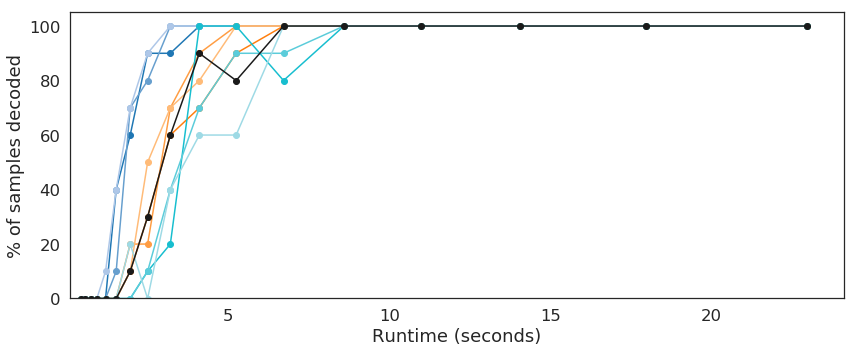

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
for i, (fname, firstd_df) in enumerate(first_d_below_maxd.groupby("fname")):
    if fname not in label_order:
        continue
    color = color_by_file[fname]
    label = files_and_labels.get(fname)
    no_na = firstd_df.dropna(inplace=False)
    no_decoding = firstd_df.drop(no_na.index, inplace=False)
    frac = []
    runtime = []
    for sample_depth in np.unique(firstd_df["sample_depth"]):
        if sample_depth > 1800:
            break
        nd = len(no_decoding[no_decoding["sample_depth"] == sample_depth])
        frac.append(100. * (10 - nd) / 10)
        runtime.append(sample_depth / 4000 * 60)
    ax.plot(runtime, frac, marker="o", c=color, label=label)
    
ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("% of samples decoded")
ax.set_ylim([0.1, ax.get_ylim()[1]])
ax.set_xlim([0.1, ax.get_xlim()[1]])
# ax.legend()
fig.tight_layout()


# fig.savefig("../plots/time_to_decode/decoding_ability_over_time_leftend.png", dpi=300)
# fig.savefig("../plots/time_to_decode/decoding_ability_over_time_leftend.svg")

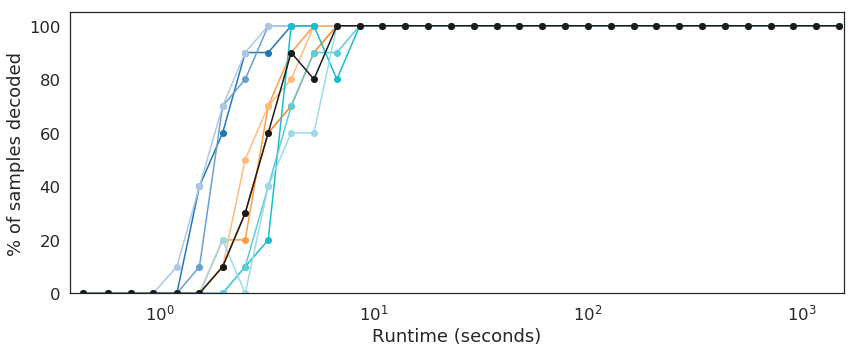

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
for i, (fname, firstd_df) in enumerate(first_d_below_maxd.groupby("fname")):
    if fname not in label_order:
        continue
    color = color_by_file[fname]
    label = files_and_labels.get(fname)
    no_na = firstd_df.dropna(inplace=False)
    no_decoding = firstd_df.drop(no_na.index, inplace=False)
    frac = []
    runtime = []
    for sample_depth in np.unique(firstd_df["sample_depth"]):
        nd = len(no_decoding[no_decoding["sample_depth"] == sample_depth])
        frac.append(100. * (10 - nd) / 10)
        runtime.append(sample_depth / 4000. * 60)
    ax.plot(runtime, frac, marker="o", c=color, label=label)
    
ax.set_xscale("log")
ax.set_xlabel("Runtime (seconds)")
ax.set_ylabel("% of samples decoded")
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlim([0.38, 1575])
fig.tight_layout()

# ax.legend()
fig.savefig("../plots/time_to_decode/decoding_ability_over_time.png", dpi=300)
fig.savefig("../plots/time_to_decode/decoding_ability_over_time.svg")


Average bit error rate

In [17]:
errs = []
for fname, fname_df in closest_depth_df.groupby("fname"):
    errs_over_time_data[fname] = {}
    sampled_runtime = []
    mean_dist = []
    std_dist = []
    # incorrect_depth = []
    # incorrect_dist = []
    for depth, df in fname_df.groupby("sample_depth"):
        sampled_runtime.append(depth / 4000. * 60)
        mean_dist.append(np.mean(df["closest_d"]))
        std_dist.append(np.std(df["closest_d"]))

    errs_over_time_data[fname]["sampled_runtime"] = sampled_runtime
    errs_over_time_data[fname]["mean_dist"] = mean_dist
    errs_over_time_data[fname]["std_dist"] = std_dist
    
    df = fname_df[fname_df["correct_decoding"] == False]
    depths = df["sample_depth"]/ 4000. * 60
    dists = df["closest_d"] 
    
    errs_over_time_data[fname]["incorrect_pts"] = list(zip(depths, dists))